# Quantum Wave Visualizer

In [101]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.animation import FuncAnimation
from scipy.linalg import eigh
from IPython.display import HTML

sns.set_theme()

In [102]:
# Constants
hbar = 1.0  # Reduced Planck's constant
m = 1.0  # Mass of the particle

In [103]:
def define_grid(grid_size, x_min, x_max):
	"""
    Define the spatial grid and return the grid points and step size.
    """
	x = np.linspace(x_min, x_max, grid_size +1)
	dx = (x_max - x_min) / grid_size
	return x, dx

In [104]:
# Potentials
def potential_square_well(x, well_width, well_depth):
	"""
    Define a square well potential centered at x=0.
    """
	V = np.zeros_like(x)
	V[np.abs(x) <= well_width / 2] = -well_depth
	return V

def potential_harmonic_oscillator(x, k, x0=0):
	"""
    Define a harmonic oscillator potential.
    """
	return 0.5 * k * (x - x0) ** 2


def potential_free_particle(x):
	"""
    Define a free particle potential (V=0 everywhere).
    """
	return np.zeros_like(x)


def potential_custom(x, custom_func):
	"""
    Define a customizable potential using a function.
    """
	return custom_func(x)

In [105]:
def construct_hamiltonian(x, dx, V):
	"""
    Construct the Hamiltonian operator as a sparse matrix.
    """
	N = len(x)
	kinetic_coefficient = hbar ** 2 / (2 * m * dx ** 2)
	kinetic = kinetic_coefficient * (np.eye(N, k=1) + np.eye(N, k=-1) - 2 * np.eye(N))

	potential = np.diag(V)

	return kinetic + potential

In [106]:
def solve_schrodinger(H):
	"""
    Solve the time-independent Schrödinger equation for eigenvalues/eigenvectors.
    """
	return eigh(H)


In [107]:
def wavefunction_evolution(eigenvectors, eigenvalues, x, t, c_n):
	"""
    Compute the time-evolved wavefunction psi(x, t).
    """

	# Time-evolve the wavefunction
	psi_t = np.zeros_like(x, dtype=complex)
	for n, (psi_n, E_n) in enumerate(zip(eigenvectors.T, eigenvalues)):
		psi_t += c_n[n] * psi_n * np.exp(-1j * E_n * t / hbar)
	return np.abs(psi_t) ** 2


In [108]:
def get_coefficients(x, eigenvectors, dx):
	"""
    Compute the coefficients of a Gaussian initial wavefunction (phi) projected
    onto the eigenfunctions of the Hamiltonian.
    
    Parameters:
        x (numpy.ndarray): Spatial grid.
        eigenvectors (numpy.ndarray): Eigenfunctions of the system.
        dx (float): Grid spacing.
    
    Returns:
        numpy.ndarray: Normalized coefficients for the initial wavefunction.
    """
	# Define the initial Gaussian wavefunction
	phi = np.exp(-(x*4) ** 2)  # Gaussian centered at x=0
	phi /= np.sqrt(np.sum(np.abs(phi) ** 2) * dx)  # Normalize

	# Compute projection coefficients
	c_n = np.array([
		np.sum(phi * eigenvectors[:, i].conj()) * dx for i in range(len(x))
		])

	# Normalize coefficients
	c_n /= np.sqrt(np.sum(np.abs(c_n) ** 2))
	return c_n

In [109]:
def animate_wavefunction(x, dx, eigenvectors, eigenvalues, t_max, frames,
                         filename=None):
	"""
    Create an animation of the wavefunction's time evolution.

    Parameters:
        x (numpy.ndarray): Spatial grid
        eigenvectors (numpy.ndarray): Eigenfunctions from the Hamiltonian
        eigenvalues (numpy.ndarray): Eigenvalues from the Hamiltonian
        t_max (float): Total time duration of the animation
        frames (int): Number of frames for the animation
        filename (str): Optional filename to save the animation
    """
	time_points = np.linspace(0, t_max, frames)
	c_n = get_coefficients(x, eigenvectors, dx)

	# Set up the figure
	fig, ax = plt.subplots(figsize=(8, 6))
	ax.set_xlim(x.min(), x.max())
	ax.set_ylim(0, 1.2)
	ax.set_title("Time Evolution of the Probability Density")
	ax.set_xlabel("x")
	ax.set_ylabel(r"$|\psi(x,t)|^2$")
	line, = ax.plot([], [], label=fr'$|\psi(x, t)|^2$')
	ax.legend()
	ax.grid()

	def init():
		"""Initialize the plot."""
		line.set_data([], [])
		return line,

	def update(frame):
		"""Update the wavefunction for the given frame."""
		t = time_points[frame]
		psi_t = wavefunction_evolution(eigenvectors, eigenvalues, x, t, c_n=c_n)
		line.set_data(x, psi_t)
		return line,

	# Create animation
	anim = FuncAnimation(fig, update, frames=frames, init_func=init, blit=True,
	                     interval=6000*t_max/frames)

	# Display animation
	HTML(anim.to_jshtml())

	# Save animation if needed
	if filename:
		anim.save(filename, writer='ffmpeg', fps=30)

In [110]:
def check_normalization(psi, dx):
	norm = np.sum(psi * dx)
	print(f"Normalization: {norm}")

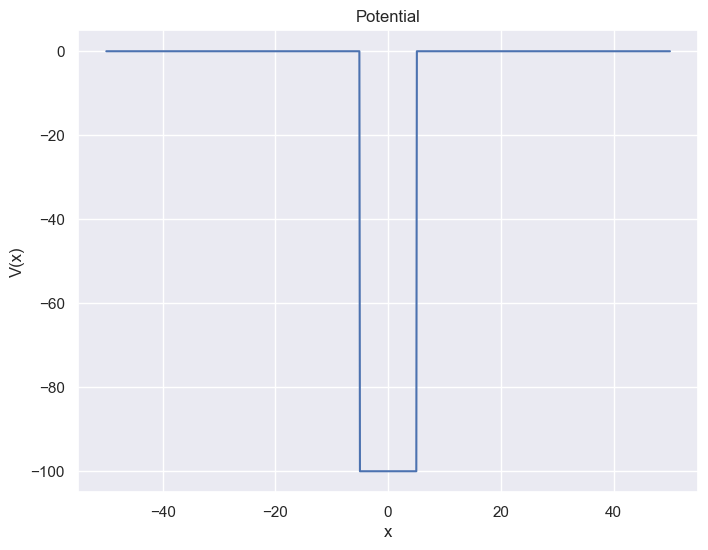

Animation size has reached 20984740 bytes, exceeding the limit of 20971520.0. If you're sure you want a larger animation embedded, set the animation.embed_limit rc parameter to a larger value (in MB). This and further frames will be dropped.


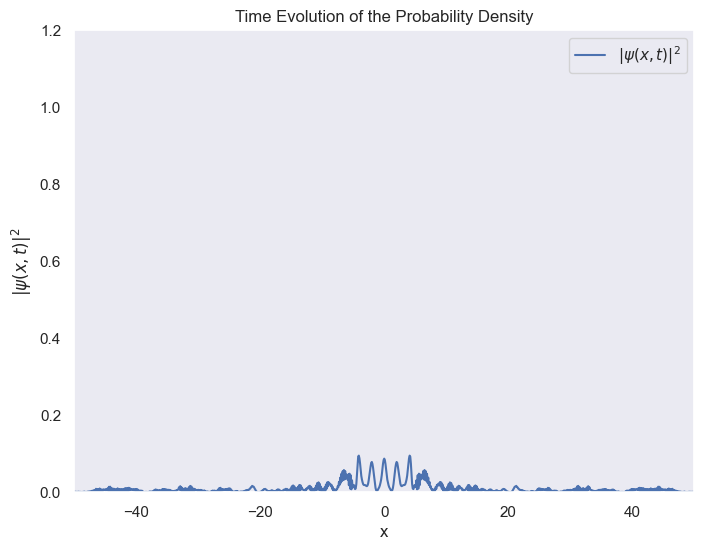

In [111]:
def main():
	# Parameters
	grid_size = 1000
	x_min, x_max = -50, 50
	well_width = 10.0
	well_depth = 100
	t_max = 10.0
	frames = 1000

	# Grid and potential
	x, dx = define_grid(grid_size, x_min, x_max)
	V = potential_square_well(x, well_width, well_depth)

	# show starting position
	# ! to be added

	# show potential
	fig, ax = plt.subplots(figsize=(8, 6))
	plt.plot(x, V)
	ax.set(title="Potential", xlabel="x", ylabel="V(x)")
	plt.show()

	# Hamiltonian and solutions
	H = construct_hamiltonian(x, dx, V)
	eigenvalues, eigenvectors = solve_schrodinger(H)

	# normalize eigenfunctions
	for i in range(eigenvectors.shape[1]):
		eigenvectors[:, i] /= np.sqrt(np.sum(np.abs(eigenvectors[:, i]) ** 2) * dx)

	# Animate the wavefunction evolution
	animate_wavefunction(x, dx, eigenvectors, eigenvalues, t_max,
	                     frames, filename="wavefunction.mp4")

if __name__ == "__main__":
	main()